In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [20]:
data_dir = Path('./data/')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 7
n_class = 3
seed = 42

In [5]:
algo_name = 'lgbcv_last'
feature_name = 'stacking'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [7]:
model_names = ['rf_cv_last1_feature', 'rf_cv_last2_feature', 'lrcv_last1_polyfeature', 'lrcv_last2_polyfeature', 'lgbcv_last1_feature', 'lgbcv_last2_feature', 'lgb_hyperopt_last1_feature', 'lgb_hyperopt_last2_feature', 'lgb_hyperopt_last3_feature', 'lgb_hyperopt_last4_feature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(data_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(data_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['rf_cv_last1_feature_class0',
 'rf_cv_last1_feature_class1',
 'rf_cv_last1_feature_class2',
 'rf_cv_last2_feature_class0',
 'rf_cv_last2_feature_class1',
 'rf_cv_last2_feature_class2',
 'lrcv_last1_polyfeature_class0',
 'lrcv_last1_polyfeature_class1',
 'lrcv_last1_polyfeature_class2',
 'lrcv_last2_polyfeature_class0',
 'lrcv_last2_polyfeature_class1',
 'lrcv_last2_polyfeature_class2',
 'lgbcv_last1_feature_class0',
 'lgbcv_last1_feature_class1',
 'lgbcv_last1_feature_class2',
 'lgbcv_last2_feature_class0',
 'lgbcv_last2_feature_class1',
 'lgbcv_last2_feature_class2',
 'lgb_hyperopt_last1_feature_class0',
 'lgb_hyperopt_last1_feature_class1',
 'lgb_hyperopt_last1_feature_class2',
 'lgb_hyperopt_last2_feature_class0',
 'lgb_hyperopt_last2_feature_class1',
 'lgb_hyperopt_last2_feature_class2',
 'lgb_hyperopt_last3_feature_class0',
 'lgb_hyperopt_last3_feature_class1',
 'lgb_hyperopt_last3_feature_class2',
 'lgb_hyperopt_last4_feature_class0',
 'lgb_hyperopt_last4_feature_class1',
 'lgb_

In [8]:
trn.shape

(320000, 30)

In [9]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

In [10]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [21]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             boosting_type='gbdt',
                             num_iterations =14278,
                             max_depth=50,
                             n_estimators =16608,
                             num_leaves=255,
                             learning_rate=0.0142,
                             min_child_samples=173,
                             subsample=.9,
                             subsample_freq=1,
                             colsample_bytree=.6,
                             # bagging_fraction=0.3,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=100)
    
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.963261
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.941436
[3]	valid_0's multi_logloss: 0.920513
[4]	valid_0's multi_logloss: 0.900418
[5]	valid_0's multi_logloss: 0.88104
[6]	valid_0's multi_logloss: 0.862389
[7]	valid_0's multi_logloss: 0.844395
[8]	valid_0's multi_logloss: 0.827007
[9]	valid_0's multi_logloss: 0.81021
[10]	valid_0's multi_logloss: 0.793999
[11]	valid_0's multi_logloss: 0.778335
[12]	valid_0's multi_logloss: 0.76317
[13]	valid_0's multi_logloss: 0.748462
[14]	valid_0's multi_logloss: 0.734235
[15]	valid_0's multi_logloss: 0.72047
[16]	valid_0's multi_logloss: 0.707087
[17]	valid_0's multi_logloss: 0.694114
[18]	valid_0's multi_logloss: 0.681534
[19]	valid_0's multi_logloss: 0.669321
[20]	valid_0's multi_logloss: 0.657451
[21]	valid_0's multi_logloss: 0.645925
[22]	valid_0's multi_logloss: 0.634704
[23]	valid_0's multi_logloss: 0.623808
[24]	valid_0's multi_logloss:

[208]	valid_0's multi_logloss: 0.169325
[209]	valid_0's multi_logloss: 0.16909
[210]	valid_0's multi_logloss: 0.168864
[211]	valid_0's multi_logloss: 0.168628
[212]	valid_0's multi_logloss: 0.168408
[213]	valid_0's multi_logloss: 0.168183
[214]	valid_0's multi_logloss: 0.167968
[215]	valid_0's multi_logloss: 0.167754
[216]	valid_0's multi_logloss: 0.167527
[217]	valid_0's multi_logloss: 0.167312
[218]	valid_0's multi_logloss: 0.167117
[219]	valid_0's multi_logloss: 0.166909
[220]	valid_0's multi_logloss: 0.166723
[221]	valid_0's multi_logloss: 0.16652
[222]	valid_0's multi_logloss: 0.166341
[223]	valid_0's multi_logloss: 0.166153
[224]	valid_0's multi_logloss: 0.165968
[225]	valid_0's multi_logloss: 0.165787
[226]	valid_0's multi_logloss: 0.165609
[227]	valid_0's multi_logloss: 0.165437
[228]	valid_0's multi_logloss: 0.165262
[229]	valid_0's multi_logloss: 0.165081
[230]	valid_0's multi_logloss: 0.164916
[231]	valid_0's multi_logloss: 0.164755
[232]	valid_0's multi_logloss: 0.164602
[2

[416]	valid_0's multi_logloss: 0.155469
[417]	valid_0's multi_logloss: 0.155466
[418]	valid_0's multi_logloss: 0.155465
[419]	valid_0's multi_logloss: 0.155449
[420]	valid_0's multi_logloss: 0.155436
[421]	valid_0's multi_logloss: 0.15543
[422]	valid_0's multi_logloss: 0.155427
[423]	valid_0's multi_logloss: 0.155424
[424]	valid_0's multi_logloss: 0.155407
[425]	valid_0's multi_logloss: 0.155397
[426]	valid_0's multi_logloss: 0.155388
[427]	valid_0's multi_logloss: 0.155383
[428]	valid_0's multi_logloss: 0.155372
[429]	valid_0's multi_logloss: 0.15537
[430]	valid_0's multi_logloss: 0.155367
[431]	valid_0's multi_logloss: 0.155367
[432]	valid_0's multi_logloss: 0.155364
[433]	valid_0's multi_logloss: 0.155362
[434]	valid_0's multi_logloss: 0.155351
[435]	valid_0's multi_logloss: 0.155339
[436]	valid_0's multi_logloss: 0.155337
[437]	valid_0's multi_logloss: 0.155335
[438]	valid_0's multi_logloss: 0.155327
[439]	valid_0's multi_logloss: 0.155335
[440]	valid_0's multi_logloss: 0.15532
[44

[40]	valid_0's multi_logloss: 0.478478
[41]	valid_0's multi_logloss: 0.471687
[42]	valid_0's multi_logloss: 0.465028
[43]	valid_0's multi_logloss: 0.458558
[44]	valid_0's multi_logloss: 0.452234
[45]	valid_0's multi_logloss: 0.446061
[46]	valid_0's multi_logloss: 0.440028
[47]	valid_0's multi_logloss: 0.434152
[48]	valid_0's multi_logloss: 0.42839
[49]	valid_0's multi_logloss: 0.422764
[50]	valid_0's multi_logloss: 0.417285
[51]	valid_0's multi_logloss: 0.41192
[52]	valid_0's multi_logloss: 0.406695
[53]	valid_0's multi_logloss: 0.401582
[54]	valid_0's multi_logloss: 0.396583
[55]	valid_0's multi_logloss: 0.391703
[56]	valid_0's multi_logloss: 0.386925
[57]	valid_0's multi_logloss: 0.38227
[58]	valid_0's multi_logloss: 0.377709
[59]	valid_0's multi_logloss: 0.373246
[60]	valid_0's multi_logloss: 0.368897
[61]	valid_0's multi_logloss: 0.364636
[62]	valid_0's multi_logloss: 0.360477
[63]	valid_0's multi_logloss: 0.356407
[64]	valid_0's multi_logloss: 0.352423
[65]	valid_0's multi_logloss

[247]	valid_0's multi_logloss: 0.164069
[248]	valid_0's multi_logloss: 0.163943
[249]	valid_0's multi_logloss: 0.163816
[250]	valid_0's multi_logloss: 0.163697
[251]	valid_0's multi_logloss: 0.163579
[252]	valid_0's multi_logloss: 0.163454
[253]	valid_0's multi_logloss: 0.163333
[254]	valid_0's multi_logloss: 0.163222
[255]	valid_0's multi_logloss: 0.16311
[256]	valid_0's multi_logloss: 0.162993
[257]	valid_0's multi_logloss: 0.162887
[258]	valid_0's multi_logloss: 0.162785
[259]	valid_0's multi_logloss: 0.16268
[260]	valid_0's multi_logloss: 0.162577
[261]	valid_0's multi_logloss: 0.162473
[262]	valid_0's multi_logloss: 0.162373
[263]	valid_0's multi_logloss: 0.162276
[264]	valid_0's multi_logloss: 0.162181
[265]	valid_0's multi_logloss: 0.16209
[266]	valid_0's multi_logloss: 0.161999
[267]	valid_0's multi_logloss: 0.16191
[268]	valid_0's multi_logloss: 0.161817
[269]	valid_0's multi_logloss: 0.161729
[270]	valid_0's multi_logloss: 0.161631
[271]	valid_0's multi_logloss: 0.161547
[272

[454]	valid_0's multi_logloss: 0.156553
[455]	valid_0's multi_logloss: 0.15655
[456]	valid_0's multi_logloss: 0.156546
[457]	valid_0's multi_logloss: 0.156537
[458]	valid_0's multi_logloss: 0.156537
[459]	valid_0's multi_logloss: 0.156532
[460]	valid_0's multi_logloss: 0.156536
[461]	valid_0's multi_logloss: 0.156529
[462]	valid_0's multi_logloss: 0.156534
[463]	valid_0's multi_logloss: 0.156529
[464]	valid_0's multi_logloss: 0.156522
[465]	valid_0's multi_logloss: 0.156524
[466]	valid_0's multi_logloss: 0.156514
[467]	valid_0's multi_logloss: 0.156518
[468]	valid_0's multi_logloss: 0.156508
[469]	valid_0's multi_logloss: 0.15651
[470]	valid_0's multi_logloss: 0.156512
[471]	valid_0's multi_logloss: 0.156511
[472]	valid_0's multi_logloss: 0.156509
[473]	valid_0's multi_logloss: 0.1565
[474]	valid_0's multi_logloss: 0.156499
[475]	valid_0's multi_logloss: 0.156489
[476]	valid_0's multi_logloss: 0.156487
[477]	valid_0's multi_logloss: 0.15649
[478]	valid_0's multi_logloss: 0.156482
[479]

[60]	valid_0's multi_logloss: 0.366397
[61]	valid_0's multi_logloss: 0.362111
[62]	valid_0's multi_logloss: 0.357927
[63]	valid_0's multi_logloss: 0.353844
[64]	valid_0's multi_logloss: 0.349849
[65]	valid_0's multi_logloss: 0.345926
[66]	valid_0's multi_logloss: 0.342095
[67]	valid_0's multi_logloss: 0.338363
[68]	valid_0's multi_logloss: 0.334695
[69]	valid_0's multi_logloss: 0.331117
[70]	valid_0's multi_logloss: 0.327614
[71]	valid_0's multi_logloss: 0.32419
[72]	valid_0's multi_logloss: 0.320841
[73]	valid_0's multi_logloss: 0.317563
[74]	valid_0's multi_logloss: 0.314351
[75]	valid_0's multi_logloss: 0.31121
[76]	valid_0's multi_logloss: 0.308137
[77]	valid_0's multi_logloss: 0.305141
[78]	valid_0's multi_logloss: 0.30219
[79]	valid_0's multi_logloss: 0.299303
[80]	valid_0's multi_logloss: 0.296478
[81]	valid_0's multi_logloss: 0.293714
[82]	valid_0's multi_logloss: 0.290996
[83]	valid_0's multi_logloss: 0.288342
[84]	valid_0's multi_logloss: 0.285744
[85]	valid_0's multi_logloss

[269]	valid_0's multi_logloss: 0.15835
[270]	valid_0's multi_logloss: 0.15826
[271]	valid_0's multi_logloss: 0.158167
[272]	valid_0's multi_logloss: 0.158074
[273]	valid_0's multi_logloss: 0.157992
[274]	valid_0's multi_logloss: 0.157904
[275]	valid_0's multi_logloss: 0.157835
[276]	valid_0's multi_logloss: 0.157759
[277]	valid_0's multi_logloss: 0.157673
[278]	valid_0's multi_logloss: 0.157593
[279]	valid_0's multi_logloss: 0.157509
[280]	valid_0's multi_logloss: 0.157428
[281]	valid_0's multi_logloss: 0.15735
[282]	valid_0's multi_logloss: 0.157274
[283]	valid_0's multi_logloss: 0.157198
[284]	valid_0's multi_logloss: 0.157124
[285]	valid_0's multi_logloss: 0.157048
[286]	valid_0's multi_logloss: 0.15698
[287]	valid_0's multi_logloss: 0.156911
[288]	valid_0's multi_logloss: 0.15684
[289]	valid_0's multi_logloss: 0.156774
[290]	valid_0's multi_logloss: 0.156704
[291]	valid_0's multi_logloss: 0.156632
[292]	valid_0's multi_logloss: 0.156565
[293]	valid_0's multi_logloss: 0.156507
[294]

[475]	valid_0's multi_logloss: 0.152436
[476]	valid_0's multi_logloss: 0.152432
[477]	valid_0's multi_logloss: 0.152425
[478]	valid_0's multi_logloss: 0.152425
[479]	valid_0's multi_logloss: 0.15242
[480]	valid_0's multi_logloss: 0.152424
[481]	valid_0's multi_logloss: 0.152427
[482]	valid_0's multi_logloss: 0.152411
[483]	valid_0's multi_logloss: 0.152403
[484]	valid_0's multi_logloss: 0.152396
[485]	valid_0's multi_logloss: 0.152386
[486]	valid_0's multi_logloss: 0.152375
[487]	valid_0's multi_logloss: 0.152376
[488]	valid_0's multi_logloss: 0.152367
[489]	valid_0's multi_logloss: 0.152362
[490]	valid_0's multi_logloss: 0.152366
[491]	valid_0's multi_logloss: 0.152362
[492]	valid_0's multi_logloss: 0.152357
[493]	valid_0's multi_logloss: 0.152348
[494]	valid_0's multi_logloss: 0.152348
[495]	valid_0's multi_logloss: 0.152346
[496]	valid_0's multi_logloss: 0.152349
[497]	valid_0's multi_logloss: 0.152347
[498]	valid_0's multi_logloss: 0.152342
[499]	valid_0's multi_logloss: 0.152335
[

[42]	valid_0's multi_logloss: 0.466414
[43]	valid_0's multi_logloss: 0.459966
[44]	valid_0's multi_logloss: 0.453664
[45]	valid_0's multi_logloss: 0.44752
[46]	valid_0's multi_logloss: 0.44151
[47]	valid_0's multi_logloss: 0.435638
[48]	valid_0's multi_logloss: 0.429911
[49]	valid_0's multi_logloss: 0.424324
[50]	valid_0's multi_logloss: 0.41886
[51]	valid_0's multi_logloss: 0.41352
[52]	valid_0's multi_logloss: 0.408306
[53]	valid_0's multi_logloss: 0.403216
[54]	valid_0's multi_logloss: 0.398258
[55]	valid_0's multi_logloss: 0.393383
[56]	valid_0's multi_logloss: 0.388629
[57]	valid_0's multi_logloss: 0.383993
[58]	valid_0's multi_logloss: 0.379452
[59]	valid_0's multi_logloss: 0.375025
[60]	valid_0's multi_logloss: 0.370684
[61]	valid_0's multi_logloss: 0.366437
[62]	valid_0's multi_logloss: 0.362282
[63]	valid_0's multi_logloss: 0.358224
[64]	valid_0's multi_logloss: 0.354264
[65]	valid_0's multi_logloss: 0.350377
[66]	valid_0's multi_logloss: 0.346588
[67]	valid_0's multi_logloss:

[251]	valid_0's multi_logloss: 0.166334
[252]	valid_0's multi_logloss: 0.166215
[253]	valid_0's multi_logloss: 0.166095
[254]	valid_0's multi_logloss: 0.165986
[255]	valid_0's multi_logloss: 0.165883
[256]	valid_0's multi_logloss: 0.165777
[257]	valid_0's multi_logloss: 0.165674
[258]	valid_0's multi_logloss: 0.165571
[259]	valid_0's multi_logloss: 0.16546
[260]	valid_0's multi_logloss: 0.165371
[261]	valid_0's multi_logloss: 0.165267
[262]	valid_0's multi_logloss: 0.165165
[263]	valid_0's multi_logloss: 0.165068
[264]	valid_0's multi_logloss: 0.164976
[265]	valid_0's multi_logloss: 0.164884
[266]	valid_0's multi_logloss: 0.164777
[267]	valid_0's multi_logloss: 0.164691
[268]	valid_0's multi_logloss: 0.164592
[269]	valid_0's multi_logloss: 0.164494
[270]	valid_0's multi_logloss: 0.164396
[271]	valid_0's multi_logloss: 0.164316
[272]	valid_0's multi_logloss: 0.164239
[273]	valid_0's multi_logloss: 0.164159
[274]	valid_0's multi_logloss: 0.164081
[275]	valid_0's multi_logloss: 0.164013
[

[457]	valid_0's multi_logloss: 0.15935
[458]	valid_0's multi_logloss: 0.159341
[459]	valid_0's multi_logloss: 0.15934
[460]	valid_0's multi_logloss: 0.159324
[461]	valid_0's multi_logloss: 0.159324
[462]	valid_0's multi_logloss: 0.159315
[463]	valid_0's multi_logloss: 0.159308
[464]	valid_0's multi_logloss: 0.159305
[465]	valid_0's multi_logloss: 0.1593
[466]	valid_0's multi_logloss: 0.159304
[467]	valid_0's multi_logloss: 0.159302
[468]	valid_0's multi_logloss: 0.159308
[469]	valid_0's multi_logloss: 0.159301
[470]	valid_0's multi_logloss: 0.159316
[471]	valid_0's multi_logloss: 0.159313
[472]	valid_0's multi_logloss: 0.159315
[473]	valid_0's multi_logloss: 0.159312
[474]	valid_0's multi_logloss: 0.159322
[475]	valid_0's multi_logloss: 0.159317
[476]	valid_0's multi_logloss: 0.159329
[477]	valid_0's multi_logloss: 0.159325
[478]	valid_0's multi_logloss: 0.159327
[479]	valid_0's multi_logloss: 0.159327
[480]	valid_0's multi_logloss: 0.15933
[481]	valid_0's multi_logloss: 0.159327
[482]

[302]	valid_0's multi_logloss: 0.158663
[303]	valid_0's multi_logloss: 0.158617
[304]	valid_0's multi_logloss: 0.158566
[305]	valid_0's multi_logloss: 0.158513
[306]	valid_0's multi_logloss: 0.158468
[307]	valid_0's multi_logloss: 0.158419
[308]	valid_0's multi_logloss: 0.158372
[309]	valid_0's multi_logloss: 0.158327
[310]	valid_0's multi_logloss: 0.158278
[311]	valid_0's multi_logloss: 0.158236
[312]	valid_0's multi_logloss: 0.158191
[313]	valid_0's multi_logloss: 0.158143
[314]	valid_0's multi_logloss: 0.158108
[315]	valid_0's multi_logloss: 0.158062
[316]	valid_0's multi_logloss: 0.158024
[317]	valid_0's multi_logloss: 0.157979
[318]	valid_0's multi_logloss: 0.157936
[319]	valid_0's multi_logloss: 0.157893
[320]	valid_0's multi_logloss: 0.157853
[321]	valid_0's multi_logloss: 0.157811
[322]	valid_0's multi_logloss: 0.157773
[323]	valid_0's multi_logloss: 0.15773
[324]	valid_0's multi_logloss: 0.157693
[325]	valid_0's multi_logloss: 0.157658
[326]	valid_0's multi_logloss: 0.157622
[

[509]	valid_0's multi_logloss: 0.155498
[510]	valid_0's multi_logloss: 0.155491
[511]	valid_0's multi_logloss: 0.155487
[512]	valid_0's multi_logloss: 0.155486
[513]	valid_0's multi_logloss: 0.155486
[514]	valid_0's multi_logloss: 0.155481
[515]	valid_0's multi_logloss: 0.155484
[516]	valid_0's multi_logloss: 0.155486
[517]	valid_0's multi_logloss: 0.155497
[518]	valid_0's multi_logloss: 0.1555
[519]	valid_0's multi_logloss: 0.155506
[520]	valid_0's multi_logloss: 0.155506
[521]	valid_0's multi_logloss: 0.1555
[522]	valid_0's multi_logloss: 0.155503
[523]	valid_0's multi_logloss: 0.155511
[524]	valid_0's multi_logloss: 0.155514
[525]	valid_0's multi_logloss: 0.155516
[526]	valid_0's multi_logloss: 0.155514
[527]	valid_0's multi_logloss: 0.155515
[528]	valid_0's multi_logloss: 0.155506
[529]	valid_0's multi_logloss: 0.155502
[530]	valid_0's multi_logloss: 0.155502
[531]	valid_0's multi_logloss: 0.155501
[532]	valid_0's multi_logloss: 0.155495
[533]	valid_0's multi_logloss: 0.155511
[534

[100]	valid_0's multi_logloss: 0.257062
[101]	valid_0's multi_logloss: 0.255247
[102]	valid_0's multi_logloss: 0.253468
[103]	valid_0's multi_logloss: 0.251728
[104]	valid_0's multi_logloss: 0.25002
[105]	valid_0's multi_logloss: 0.248346
[106]	valid_0's multi_logloss: 0.246704
[107]	valid_0's multi_logloss: 0.24509
[108]	valid_0's multi_logloss: 0.243515
[109]	valid_0's multi_logloss: 0.241978
[110]	valid_0's multi_logloss: 0.240466
[111]	valid_0's multi_logloss: 0.23898
[112]	valid_0's multi_logloss: 0.237528
[113]	valid_0's multi_logloss: 0.236103
[114]	valid_0's multi_logloss: 0.234706
[115]	valid_0's multi_logloss: 0.233338
[116]	valid_0's multi_logloss: 0.231985
[117]	valid_0's multi_logloss: 0.230668
[118]	valid_0's multi_logloss: 0.229384
[119]	valid_0's multi_logloss: 0.228117
[120]	valid_0's multi_logloss: 0.226871
[121]	valid_0's multi_logloss: 0.22566
[122]	valid_0's multi_logloss: 0.224466
[123]	valid_0's multi_logloss: 0.223288
[124]	valid_0's multi_logloss: 0.222136
[125

[306]	valid_0's multi_logloss: 0.161817
[307]	valid_0's multi_logloss: 0.161767
[308]	valid_0's multi_logloss: 0.161717
[309]	valid_0's multi_logloss: 0.16167
[310]	valid_0's multi_logloss: 0.161621
[311]	valid_0's multi_logloss: 0.161575
[312]	valid_0's multi_logloss: 0.161526
[313]	valid_0's multi_logloss: 0.161479
[314]	valid_0's multi_logloss: 0.161435
[315]	valid_0's multi_logloss: 0.161382
[316]	valid_0's multi_logloss: 0.16133
[317]	valid_0's multi_logloss: 0.161294
[318]	valid_0's multi_logloss: 0.16125
[319]	valid_0's multi_logloss: 0.161207
[320]	valid_0's multi_logloss: 0.161154
[321]	valid_0's multi_logloss: 0.161104
[322]	valid_0's multi_logloss: 0.161057
[323]	valid_0's multi_logloss: 0.161022
[324]	valid_0's multi_logloss: 0.160985
[325]	valid_0's multi_logloss: 0.160947
[326]	valid_0's multi_logloss: 0.160914
[327]	valid_0's multi_logloss: 0.160878
[328]	valid_0's multi_logloss: 0.160836
[329]	valid_0's multi_logloss: 0.1608
[330]	valid_0's multi_logloss: 0.160751
[331]

[80]	valid_0's multi_logloss: 0.297159
[81]	valid_0's multi_logloss: 0.294395
[82]	valid_0's multi_logloss: 0.291679
[83]	valid_0's multi_logloss: 0.289023
[84]	valid_0's multi_logloss: 0.286425
[85]	valid_0's multi_logloss: 0.283881
[86]	valid_0's multi_logloss: 0.281369
[87]	valid_0's multi_logloss: 0.278925
[88]	valid_0's multi_logloss: 0.276521
[89]	valid_0's multi_logloss: 0.274181
[90]	valid_0's multi_logloss: 0.271886
[91]	valid_0's multi_logloss: 0.269637
[92]	valid_0's multi_logloss: 0.267432
[93]	valid_0's multi_logloss: 0.265272
[94]	valid_0's multi_logloss: 0.263157
[95]	valid_0's multi_logloss: 0.261083
[96]	valid_0's multi_logloss: 0.259049
[97]	valid_0's multi_logloss: 0.257062
[98]	valid_0's multi_logloss: 0.255124
[99]	valid_0's multi_logloss: 0.253208
[100]	valid_0's multi_logloss: 0.251346
[101]	valid_0's multi_logloss: 0.249516
[102]	valid_0's multi_logloss: 0.24773
[103]	valid_0's multi_logloss: 0.245975
[104]	valid_0's multi_logloss: 0.244256
[105]	valid_0's multi

[288]	valid_0's multi_logloss: 0.15715
[289]	valid_0's multi_logloss: 0.157079
[290]	valid_0's multi_logloss: 0.157021
[291]	valid_0's multi_logloss: 0.156951
[292]	valid_0's multi_logloss: 0.15688
[293]	valid_0's multi_logloss: 0.156822
[294]	valid_0's multi_logloss: 0.156758
[295]	valid_0's multi_logloss: 0.156702
[296]	valid_0's multi_logloss: 0.156648
[297]	valid_0's multi_logloss: 0.156599
[298]	valid_0's multi_logloss: 0.156539
[299]	valid_0's multi_logloss: 0.156489
[300]	valid_0's multi_logloss: 0.156434
[301]	valid_0's multi_logloss: 0.156381
[302]	valid_0's multi_logloss: 0.156336
[303]	valid_0's multi_logloss: 0.15629
[304]	valid_0's multi_logloss: 0.156234
[305]	valid_0's multi_logloss: 0.156186
[306]	valid_0's multi_logloss: 0.156137
[307]	valid_0's multi_logloss: 0.1561
[308]	valid_0's multi_logloss: 0.156057
[309]	valid_0's multi_logloss: 0.156008
[310]	valid_0's multi_logloss: 0.155957
[311]	valid_0's multi_logloss: 0.155909
[312]	valid_0's multi_logloss: 0.15586
[313]	

[495]	valid_0's multi_logloss: 0.153516
[496]	valid_0's multi_logloss: 0.153522
[497]	valid_0's multi_logloss: 0.153525
[498]	valid_0's multi_logloss: 0.153528
[499]	valid_0's multi_logloss: 0.153531
[500]	valid_0's multi_logloss: 0.153534
[501]	valid_0's multi_logloss: 0.153535
[502]	valid_0's multi_logloss: 0.153531
[503]	valid_0's multi_logloss: 0.153531
[504]	valid_0's multi_logloss: 0.153524
[505]	valid_0's multi_logloss: 0.153526
[506]	valid_0's multi_logloss: 0.153513
[507]	valid_0's multi_logloss: 0.153515
[508]	valid_0's multi_logloss: 0.153514
[509]	valid_0's multi_logloss: 0.15351
[510]	valid_0's multi_logloss: 0.153514
[511]	valid_0's multi_logloss: 0.153507
[512]	valid_0's multi_logloss: 0.153514
[513]	valid_0's multi_logloss: 0.153514
[514]	valid_0's multi_logloss: 0.153512
[515]	valid_0's multi_logloss: 0.153506
[516]	valid_0's multi_logloss: 0.153509
[517]	valid_0's multi_logloss: 0.153512
[518]	valid_0's multi_logloss: 0.15351
[519]	valid_0's multi_logloss: 0.153519
[5

[130]	valid_0's multi_logloss: 0.213136
[131]	valid_0's multi_logloss: 0.212138
[132]	valid_0's multi_logloss: 0.211157
[133]	valid_0's multi_logloss: 0.21019
[134]	valid_0's multi_logloss: 0.209242
[135]	valid_0's multi_logloss: 0.208326
[136]	valid_0's multi_logloss: 0.207421
[137]	valid_0's multi_logloss: 0.206534
[138]	valid_0's multi_logloss: 0.205666
[139]	valid_0's multi_logloss: 0.204809
[140]	valid_0's multi_logloss: 0.203973
[141]	valid_0's multi_logloss: 0.203142
[142]	valid_0's multi_logloss: 0.202339
[143]	valid_0's multi_logloss: 0.201545
[144]	valid_0's multi_logloss: 0.200776
[145]	valid_0's multi_logloss: 0.200018
[146]	valid_0's multi_logloss: 0.199275
[147]	valid_0's multi_logloss: 0.198543
[148]	valid_0's multi_logloss: 0.197821
[149]	valid_0's multi_logloss: 0.197119
[150]	valid_0's multi_logloss: 0.196427
[151]	valid_0's multi_logloss: 0.195747
[152]	valid_0's multi_logloss: 0.195081
[153]	valid_0's multi_logloss: 0.194421
[154]	valid_0's multi_logloss: 0.193776
[

[542]	valid_0's multi_logloss: 0.15776
[543]	valid_0's multi_logloss: 0.157758
[544]	valid_0's multi_logloss: 0.157769
[545]	valid_0's multi_logloss: 0.157779
[546]	valid_0's multi_logloss: 0.157785
[547]	valid_0's multi_logloss: 0.157784
[548]	valid_0's multi_logloss: 0.157796
[549]	valid_0's multi_logloss: 0.157799
[550]	valid_0's multi_logloss: 0.157797
[551]	valid_0's multi_logloss: 0.157792
[552]	valid_0's multi_logloss: 0.157796
[553]	valid_0's multi_logloss: 0.157792
[554]	valid_0's multi_logloss: 0.157797
[555]	valid_0's multi_logloss: 0.157819
[556]	valid_0's multi_logloss: 0.157822
[557]	valid_0's multi_logloss: 0.157808
[558]	valid_0's multi_logloss: 0.157815
[559]	valid_0's multi_logloss: 0.157819
[560]	valid_0's multi_logloss: 0.157815
[561]	valid_0's multi_logloss: 0.157824
[562]	valid_0's multi_logloss: 0.157823
[563]	valid_0's multi_logloss: 0.157828
[564]	valid_0's multi_logloss: 0.15784
[565]	valid_0's multi_logloss: 0.157839
[566]	valid_0's multi_logloss: 0.157848
[5

[173]	valid_0's multi_logloss: 0.178195
[174]	valid_0's multi_logloss: 0.177737
[175]	valid_0's multi_logloss: 0.177298
[176]	valid_0's multi_logloss: 0.176859
[177]	valid_0's multi_logloss: 0.176419
[178]	valid_0's multi_logloss: 0.176007
[179]	valid_0's multi_logloss: 0.175596
[180]	valid_0's multi_logloss: 0.175191
[181]	valid_0's multi_logloss: 0.174803
[182]	valid_0's multi_logloss: 0.174425
[183]	valid_0's multi_logloss: 0.174045
[184]	valid_0's multi_logloss: 0.173675
[185]	valid_0's multi_logloss: 0.173306
[186]	valid_0's multi_logloss: 0.172944
[187]	valid_0's multi_logloss: 0.17258
[188]	valid_0's multi_logloss: 0.172237
[189]	valid_0's multi_logloss: 0.171894
[190]	valid_0's multi_logloss: 0.171554
[191]	valid_0's multi_logloss: 0.171225
[192]	valid_0's multi_logloss: 0.170899
[193]	valid_0's multi_logloss: 0.170578
[194]	valid_0's multi_logloss: 0.170272
[195]	valid_0's multi_logloss: 0.16996
[196]	valid_0's multi_logloss: 0.169654
[197]	valid_0's multi_logloss: 0.169355
[1

[381]	valid_0's multi_logloss: 0.152418
[382]	valid_0's multi_logloss: 0.152399
[383]	valid_0's multi_logloss: 0.152387
[384]	valid_0's multi_logloss: 0.152373
[385]	valid_0's multi_logloss: 0.152358
[386]	valid_0's multi_logloss: 0.152335
[387]	valid_0's multi_logloss: 0.152328
[388]	valid_0's multi_logloss: 0.152311
[389]	valid_0's multi_logloss: 0.152298
[390]	valid_0's multi_logloss: 0.152295
[391]	valid_0's multi_logloss: 0.152289
[392]	valid_0's multi_logloss: 0.152282
[393]	valid_0's multi_logloss: 0.152268
[394]	valid_0's multi_logloss: 0.152253
[395]	valid_0's multi_logloss: 0.152239
[396]	valid_0's multi_logloss: 0.152228
[397]	valid_0's multi_logloss: 0.152209
[398]	valid_0's multi_logloss: 0.152191
[399]	valid_0's multi_logloss: 0.15218
[400]	valid_0's multi_logloss: 0.152184
[401]	valid_0's multi_logloss: 0.15218
[402]	valid_0's multi_logloss: 0.15217
[403]	valid_0's multi_logloss: 0.152155
[404]	valid_0's multi_logloss: 0.152138
[405]	valid_0's multi_logloss: 0.15213
[406

[588]	valid_0's multi_logloss: 0.15197
[589]	valid_0's multi_logloss: 0.151982
[590]	valid_0's multi_logloss: 0.151983
[591]	valid_0's multi_logloss: 0.151988
[592]	valid_0's multi_logloss: 0.152
[593]	valid_0's multi_logloss: 0.152005
[594]	valid_0's multi_logloss: 0.152008
[595]	valid_0's multi_logloss: 0.152008
[596]	valid_0's multi_logloss: 0.152003
[597]	valid_0's multi_logloss: 0.152009
[598]	valid_0's multi_logloss: 0.152009
[599]	valid_0's multi_logloss: 0.152014
[600]	valid_0's multi_logloss: 0.152013
[601]	valid_0's multi_logloss: 0.152017
[602]	valid_0's multi_logloss: 0.152022
[603]	valid_0's multi_logloss: 0.15203
[604]	valid_0's multi_logloss: 0.152035
[605]	valid_0's multi_logloss: 0.152037
[606]	valid_0's multi_logloss: 0.152039
[607]	valid_0's multi_logloss: 0.152043
[608]	valid_0's multi_logloss: 0.152046
Early stopping, best iteration is:
[508]	valid_0's multi_logloss: 0.151784
training model for CV #10
[1]	valid_0's multi_logloss: 0.963384
Training until validation 

[185]	valid_0's multi_logloss: 0.177647
[186]	valid_0's multi_logloss: 0.177285
[187]	valid_0's multi_logloss: 0.176936
[188]	valid_0's multi_logloss: 0.176583
[189]	valid_0's multi_logloss: 0.176241
[190]	valid_0's multi_logloss: 0.175909
[191]	valid_0's multi_logloss: 0.175579
[192]	valid_0's multi_logloss: 0.175254
[193]	valid_0's multi_logloss: 0.174941
[194]	valid_0's multi_logloss: 0.174629
[195]	valid_0's multi_logloss: 0.174309
[196]	valid_0's multi_logloss: 0.174008
[197]	valid_0's multi_logloss: 0.173712
[198]	valid_0's multi_logloss: 0.173412
[199]	valid_0's multi_logloss: 0.17312
[200]	valid_0's multi_logloss: 0.172829
[201]	valid_0's multi_logloss: 0.172547
[202]	valid_0's multi_logloss: 0.17228
[203]	valid_0's multi_logloss: 0.172009
[204]	valid_0's multi_logloss: 0.171751
[205]	valid_0's multi_logloss: 0.17149
[206]	valid_0's multi_logloss: 0.171241
[207]	valid_0's multi_logloss: 0.170985
[208]	valid_0's multi_logloss: 0.170741
[209]	valid_0's multi_logloss: 0.1705
[210]

[392]	valid_0's multi_logloss: 0.156516
[393]	valid_0's multi_logloss: 0.15651
[394]	valid_0's multi_logloss: 0.156503
[395]	valid_0's multi_logloss: 0.15649
[396]	valid_0's multi_logloss: 0.15647
[397]	valid_0's multi_logloss: 0.156462
[398]	valid_0's multi_logloss: 0.156447
[399]	valid_0's multi_logloss: 0.156432
[400]	valid_0's multi_logloss: 0.156411
[401]	valid_0's multi_logloss: 0.156406
[402]	valid_0's multi_logloss: 0.1564
[403]	valid_0's multi_logloss: 0.156383
[404]	valid_0's multi_logloss: 0.156364
[405]	valid_0's multi_logloss: 0.156353
[406]	valid_0's multi_logloss: 0.156343
[407]	valid_0's multi_logloss: 0.156333
[408]	valid_0's multi_logloss: 0.156325
[409]	valid_0's multi_logloss: 0.156321
[410]	valid_0's multi_logloss: 0.156308
[411]	valid_0's multi_logloss: 0.1563
[412]	valid_0's multi_logloss: 0.156282
[413]	valid_0's multi_logloss: 0.156277
[414]	valid_0's multi_logloss: 0.156265
[415]	valid_0's multi_logloss: 0.156255
[416]	valid_0's multi_logloss: 0.156248
[417]	v

In [22]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5162%


In [23]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [24]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

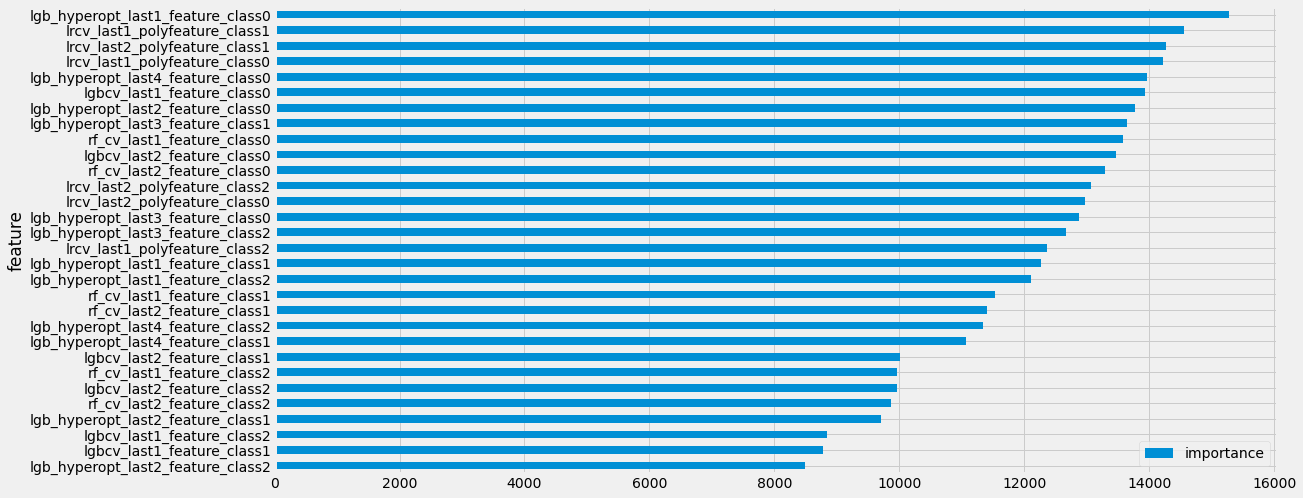

In [25]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [26]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [27]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [28]:
sub[target_col].value_counts()

2    40894
0    29980
1     9126
Name: class, dtype: int64

In [29]:
sub.to_csv(sub_file)